In [14]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
from arch import arch_model
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Add the parent directory to the system path 
import os
import sys
sys.path.append('../scripts')
from EDA_functions import *


In [6]:
df = pd.read_csv("C:/Users/elbet/OneDrive/Desktop/Ten/week-10/Change-point-analysis-and-statistical-modelling-of-time-series-data/data/BrentOilPrices.csv")
df.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [7]:
quality_checks = validate_data_quality(df)
print("\nData Quality Check Results:")
print("Missing Values:", quality_checks['missing_values'])
print("Duplicate Entries:", quality_checks['duplicates'])


Data Quality Check Results:
Missing Values: 0
Duplicate Entries: 0


##### Data processing to convert date column to standard format

In [10]:
# Convert 'Date' column to datetime with the correct format
df['Date'] = pd.to_datetime(df['Date'], format='mixed')

print(df)

           Date  Price
0    1987-05-20  18.63
1    1987-05-21  18.45
2    1987-05-22  18.55
3    1987-05-25  18.60
4    1987-05-26  18.63
...         ...    ...
9006 2022-11-08  96.85
9007 2022-11-09  93.05
9008 2022-11-10  94.25
9009 2022-11-11  96.37
9010 2022-11-14  93.59

[9011 rows x 2 columns]


##### Visualizing the data using a line plot

In [12]:
def check_stationarity(df, column='Price'):
    """
    Perform the Augmented Dickey-Fuller test for stationarity.
    """
    result = adfuller(df[column])
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("The data is stationary.")
    else:
        print("The data is non-stationary. Differencing may be needed.")


# Summary statistics
print("Descriptive statistics of Brent Oil Prices:")
display(df['Price'].describe())
check_stationarity(df)


Descriptive statistics of Brent Oil Prices:


count    9011.000000
mean       48.420782
std        32.860110
min         9.100000
25%        19.050000
50%        38.570000
75%        70.090000
max       143.950000
Name: Price, dtype: float64

ADF Statistic: -1.993856011392467
p-value: 0.2892735048934032
The data is non-stationary. Differencing may be needed.


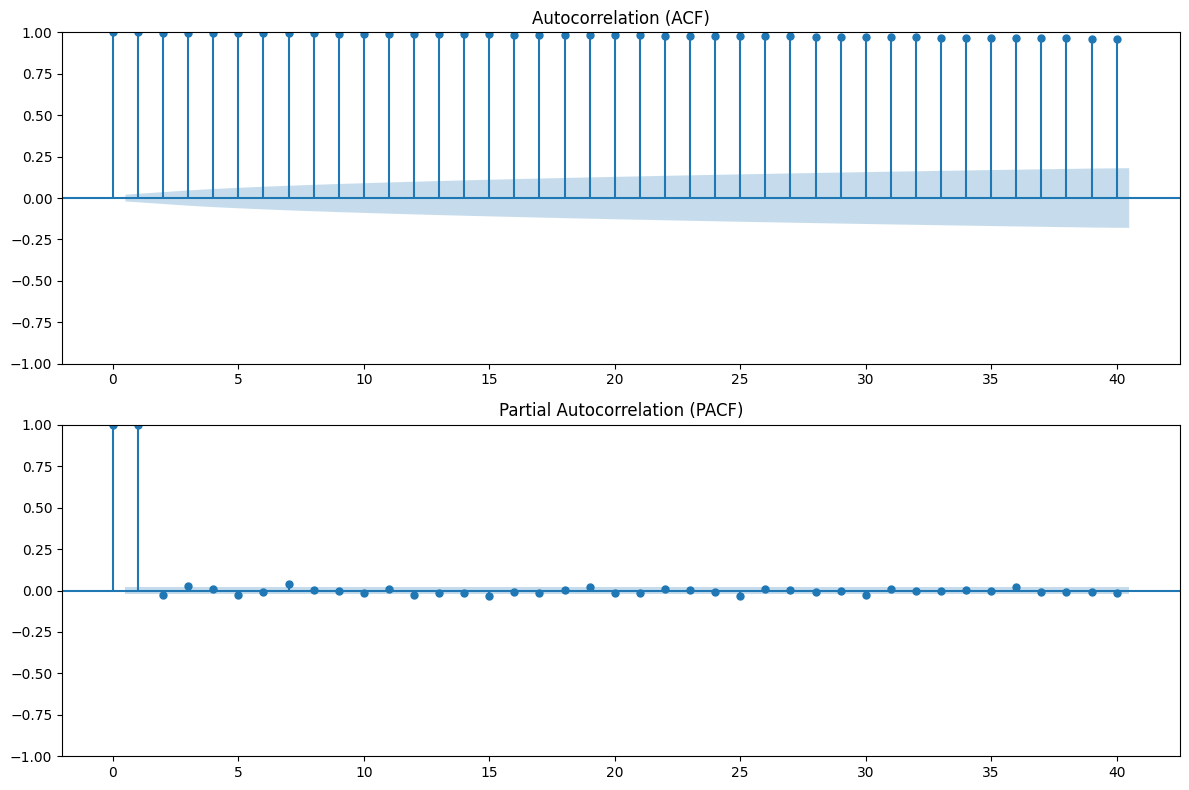

In [13]:
 # Step 1: EDA and Initial Analysis
def plot_acf_pacf(df, column='Price'):
    """
    Plot ACF and PACF for time series analysis.
    """
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(df[column], ax=ax[0])
    plot_pacf(df[column], ax=ax[1])
    ax[0].set_title("Autocorrelation (ACF)")
    ax[1].set_title("Partial Autocorrelation (PACF)")
    plt.tight_layout()
    plt.show()


plot_acf_pacf(df)

In [11]:
# Load and process the Brent oil price data with feature engineering
def load_and_process_data(file_path):
    """
    Load data, process date and price columns, and add engineered features.
    """
    # Load data
    df = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)
    df = df.sort_values(by='Date')
    
    # Ensure there are no missing values
    df = df.dropna(subset=['Price'])
    df.set_index('Date', inplace=True)
    
    # Feature Engineering
    df['Returns'] = df['Price'].pct_change()  # Daily returns
    df['Log_Returns'] = np.log(df['Price'] / df['Price'].shift(1))  # Log returns
    df['Volatility'] = df['Returns'].rolling(window=21).std()  # 21-day rolling volatility
    df['Momentum'] = df['Price'].diff(5)  # 5-day momentum
    
    # Drop any NaN values that result from rolling calculations
    df.dropna(inplace=True)
    
    return df

file_path = 'C:/Users/elbet/OneDrive/Desktop/Ten/week-10/Change-point-analysis-and-statistical-modelling-of-time-series-data/data/BrentOilPrices.csv'
df = load_and_process_data(file_path)
display(df.head(10))

,Price,Returns,Log_Returns,Volatility,Momentum
Date,,,,,
1987-06-19,19.05,0.000000,0.000000,0.004308,0.37
1987-06-22,19.10,0.002625,0.002621,0.003544,0.32
1987-06-23,18.90,-0.010471,-0.010526,0.004313,0.00
1987-06-24,18.75,-0.007937,-0.007968,0.004698,-0.28
1987-06-25,18.70,-0.002667,-0.002670,0.004736,-0.35
1987-06-26,19.08,0.020321,0.020117,0.006433,0.03
1987-06-29,19.15,0.003669,0.003662,0.006447,0.05
1987-06-30,19.08,-0.003655,-0.003662,0.006521,0.18
1987-07-01,18.98,-0.005241,-0.005255,0.006645,0.23


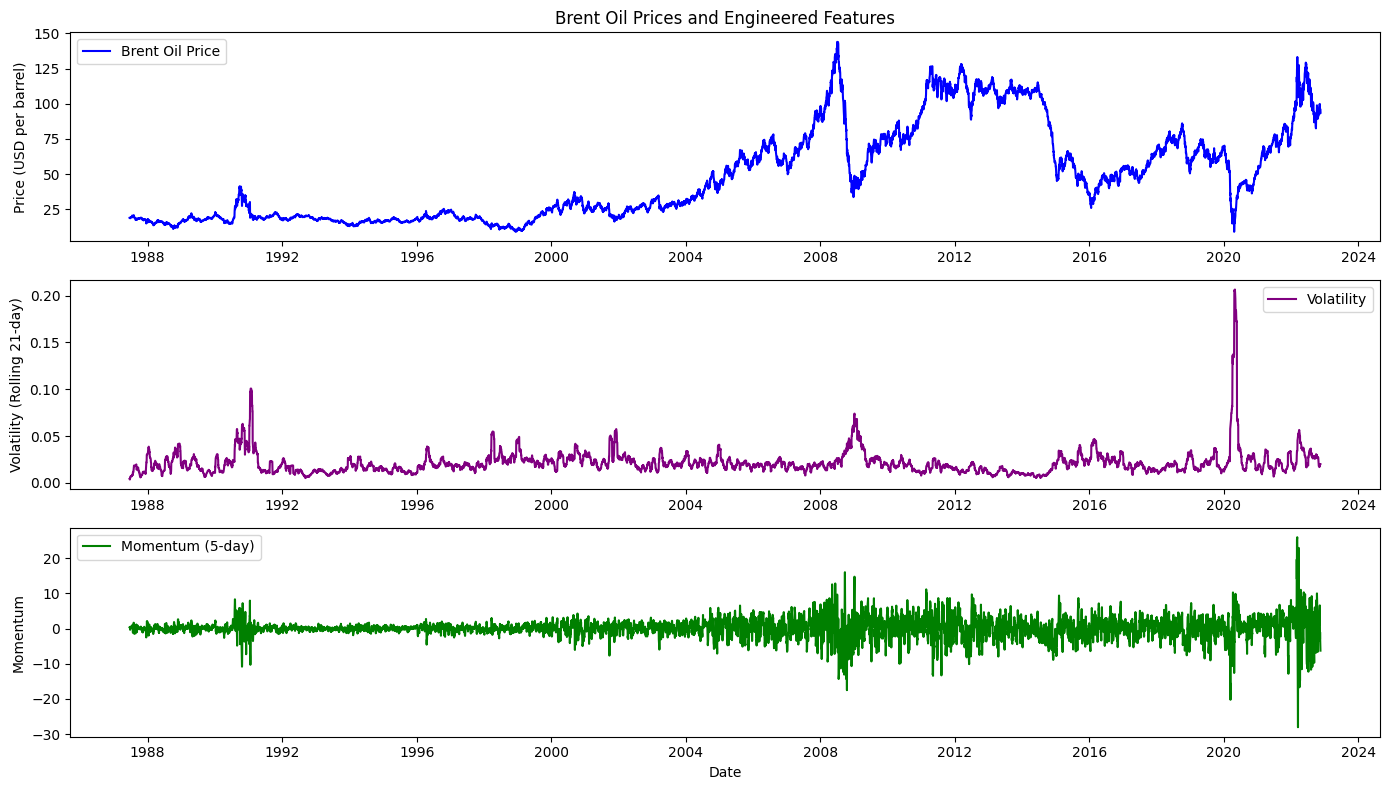

In [12]:
# Exploratory Data Analysis (EDA) - Visualization
def plot_time_series(df):
    """
    Plot the time series of Brent oil prices and engineered features.
    """
    plt.figure(figsize=(14, 8))
    
    # Plot Price
    plt.subplot(3, 1, 1)
    plt.plot(df.index, df['Price'], color='blue', label='Brent Oil Price')
    plt.title("Brent Oil Prices and Engineered Features")
    plt.ylabel("Price (USD per barrel)")
    plt.legend()

    # Plot Volatility
    plt.subplot(3, 1, 2)
    plt.plot(df.index, df['Volatility'], color='purple', label='Volatility')
    plt.ylabel("Volatility (Rolling 21-day)")
    plt.legend()
    
    # Plot Momentum
    plt.subplot(3, 1, 3)
    plt.plot(df.index, df['Momentum'], color='green', label='Momentum (5-day)')
    plt.xlabel("Date")
    plt.ylabel("Momentum")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
 
plot_time_series(df)

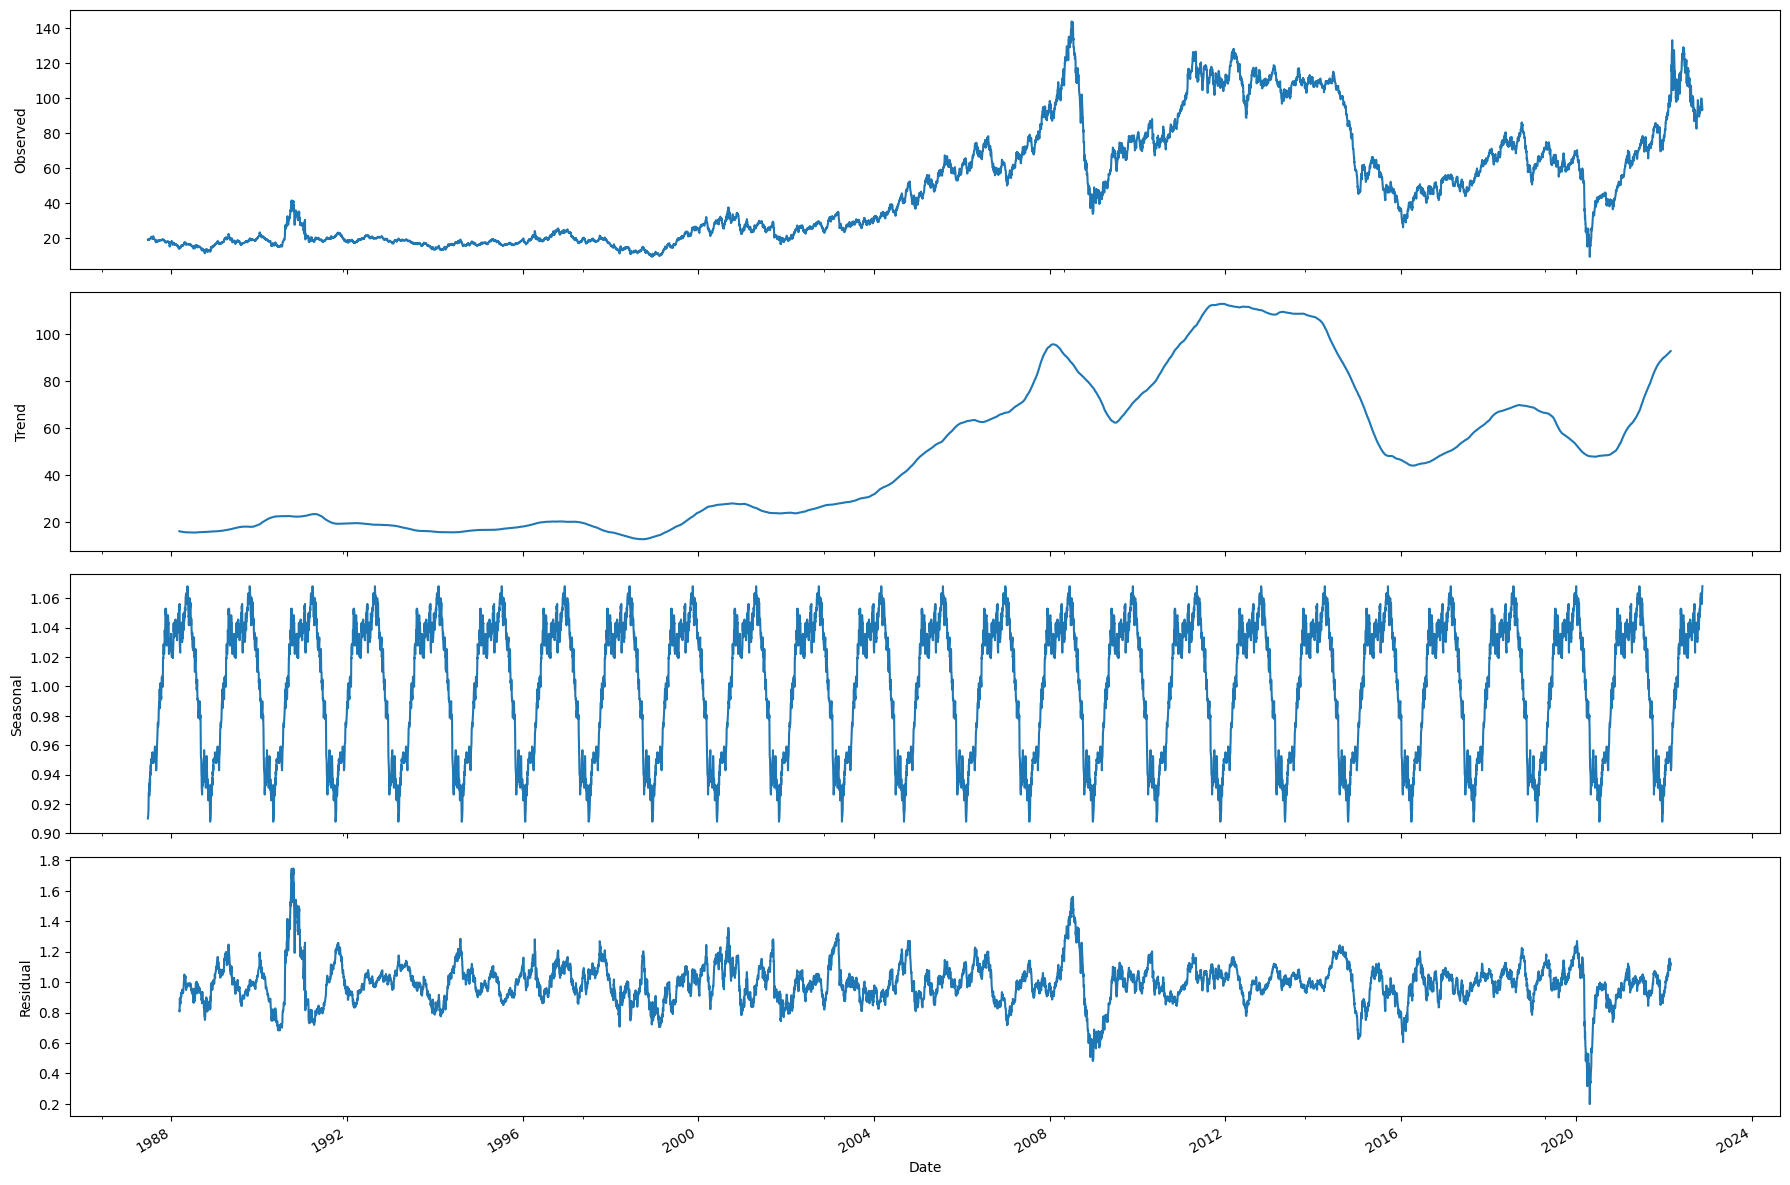

In [15]:
# Seasonality Analysis
def seasonality_analysis(df):
    """
    Perform seasonal decomposition to analyze trends, seasonality, and residuals with a wider layout.
    """
    decomposition = seasonal_decompose(df['Price'], model='multiplicative', period=365)

    # Set up a wider figure
    fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharex=True)
    
    # Plot each component with wider axes
    decomposition.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    
    decomposition.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    
    decomposition.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    
    decomposition.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')
    
    plt.tight_layout()
    plt.show()

seasonality_analysis(df)

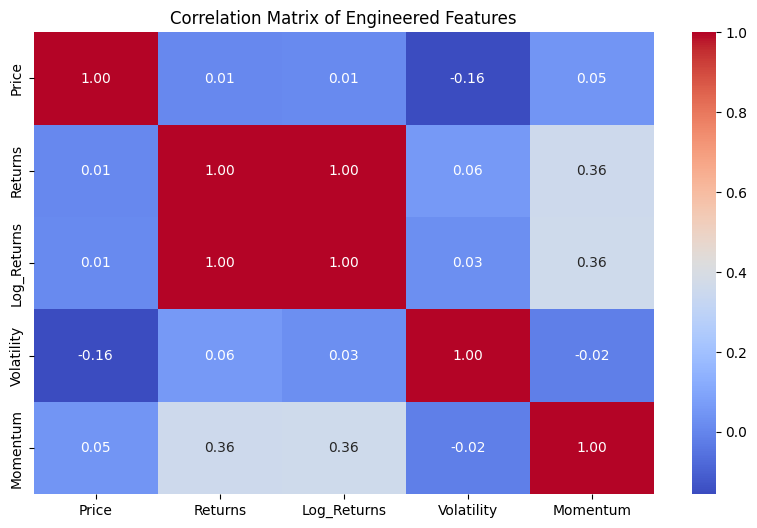

In [17]:
def correlation_analysis(df):
    """
    Plot a heatmap to show correlation among features.
    """
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Engineered Features")
    plt.show()

correlation_analysis(df)

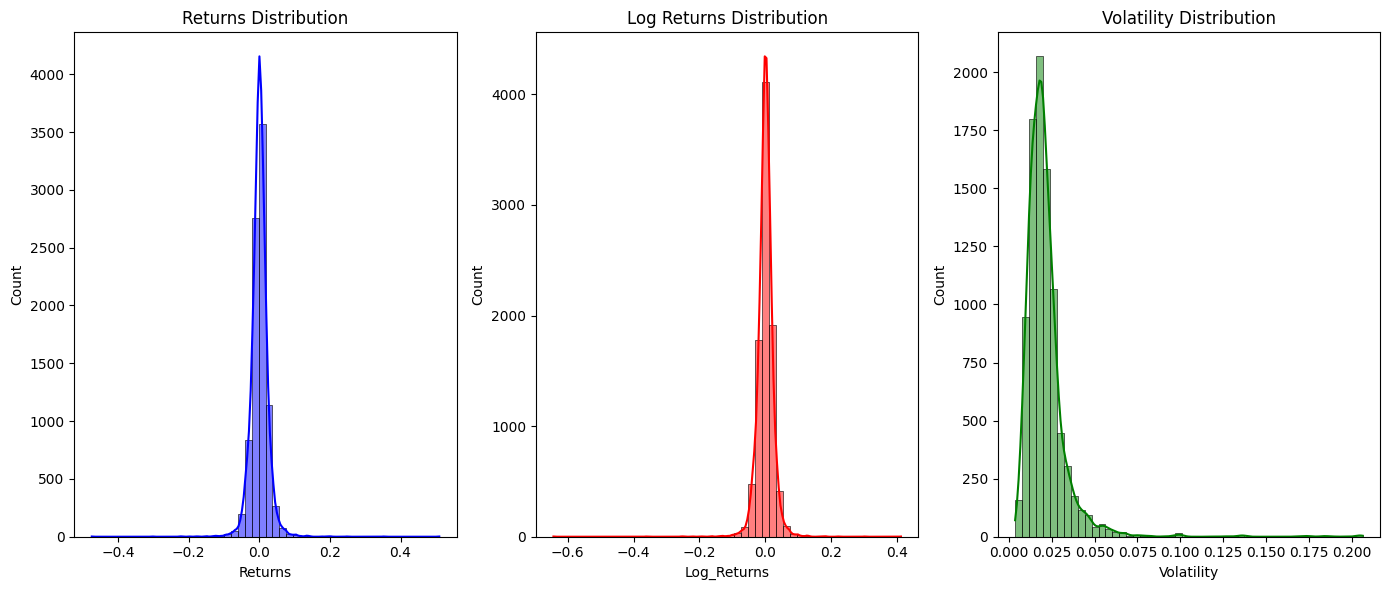

In [19]:

# Distribution Analysis
def distribution_analysis(df):
    """
    Visualize distributions of key features: Returns, Log Returns, and Volatility.
    """
    plt.figure(figsize=(14, 6))
    
    # Returns Distribution
    plt.subplot(1, 3, 1)
    sns.histplot(df['Returns'], bins=50, color='blue', kde=True)
    plt.title("Returns Distribution")

    # Log Returns Distribution
    plt.subplot(1, 3, 2)
    sns.histplot(df['Log_Returns'], bins=50, color='red', kde=True)
    plt.title("Log Returns Distribution")
    
    # Volatility Distribution
    plt.subplot(1, 3, 3)
    sns.histplot(df['Volatility'], bins=50, color='green', kde=True)
    plt.title("Volatility Distribution")
    
    plt.tight_layout()
    plt.show()

distribution_analysis(df)

#### Calculate Value at Risk (VaR) and Expected Shortfall (ES) for returns.

In [20]:
# Risk Metrics Calculation
def calculate_risk_metrics(df, confidence_level=0.05):
   
    var = np.percentile(df['Returns'].dropna(), 100 * confidence_level)
    es = df['Returns'][df['Returns'] <= var].mean()
    
    print(f"Value at Risk (VaR) at {confidence_level*100}% confidence level: {var:.4f}")
    print(f"Expected Shortfall (ES) at {confidence_level*100}% confidence level: {es:.4f}")


calculate_risk_metrics(df)

Value at Risk (VaR) at 5.0% confidence level: -0.0358
Expected Shortfall (ES) at 5.0% confidence level: -0.0546


In [23]:
# Define ARIMA Model
def arima_model(df, column='Price', p=1, d=1, q=1):
    """
    Fit ARIMA model and print summary.
    """
    model = ARIMA(df[column], order=(p, d, q))
    arima_result = model.fit()
    print(arima_result.summary())
    return arima_result

# Step 2: Model the data with ARIMA and GARCH
print("Fitting ARIMA model...")
arima_result = arima_model(df)

Fitting ARIMA model...
                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 8990
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14520.492
Date:                Sat, 02 Nov 2024   AIC                          29046.985
Time:                        15:23:11   BIC                          29068.296
Sample:                             0   HQIC                         29054.237
                               - 8990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3427      0.160     -2.147      0.032      -0.656      -0.030
ma.L1          0.3712      0.158      2.353      0.019       0.062       0.680
sigma2         1.4812      0.

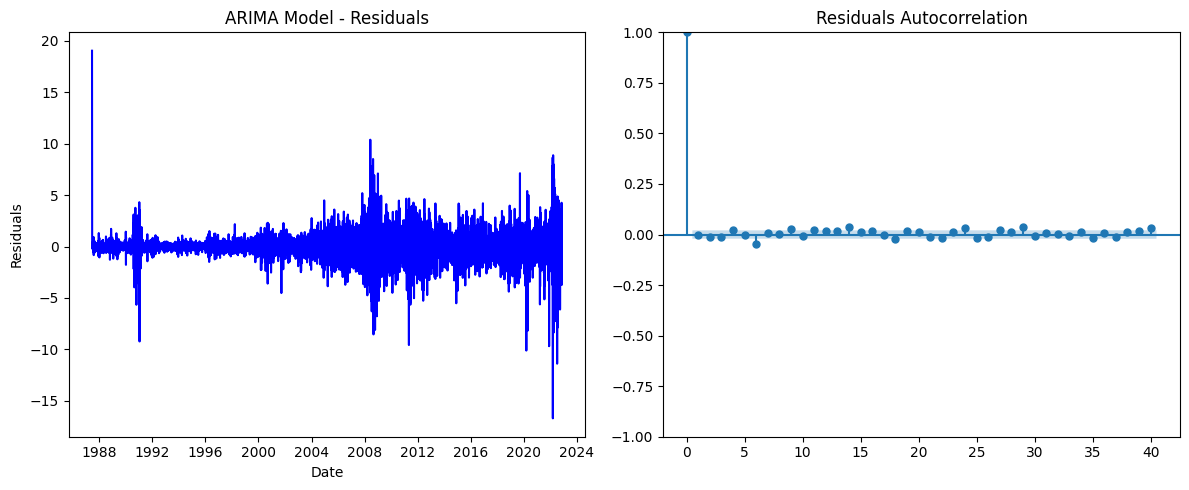

In [25]:
 #Residual Analysis for ARIMA and GARCH Models
def residual_analysis(model_results, title="Model Residuals"):
    """
    Plot residuals and ACF of residuals to check for white noise.
    """
    residuals = model_results.resid
    plt.figure(figsize=(12, 5))
    
    # Plot Residuals
    plt.subplot(1, 2, 1)
    plt.plot(residuals, color='blue')
    plt.title(f"{title} - Residuals")
    plt.xlabel("Date")
    plt.ylabel("Residuals")
    
    # Plot ACF of Residuals
    plt.subplot(1, 2, 2)
    plot_acf(residuals.dropna(), ax=plt.gca())
    plt.title("Residuals Autocorrelation")
    
    plt.tight_layout()
    plt.show()
 # Residual Analysis for ARIMA
residual_analysis(arima_result, title="ARIMA Model")

In [24]:
# Define GARCH Model
def garch_model(df, column='Price'):
    """
    Fit GARCH model to capture volatility.
    """
    model = arch_model(df[column], vol='Garch', p=1, q=1)
    garch_result = model.fit(disp="off")
    print(garch_result.summary())
    return garch_result

print("Fitting GARCH model for volatility analysis...")
garch_result = garch_model(df)


Fitting GARCH model for volatility analysis...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -35208.1
Distribution:                  Normal   AIC:                           70424.2
Method:            Maximum Likelihood   BIC:                           70452.7
                                        No. Observations:                 8990
Date:                Sat, Nov 02 2024   Df Residuals:                     8989
Time:                        15:23:14   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            18.5817  

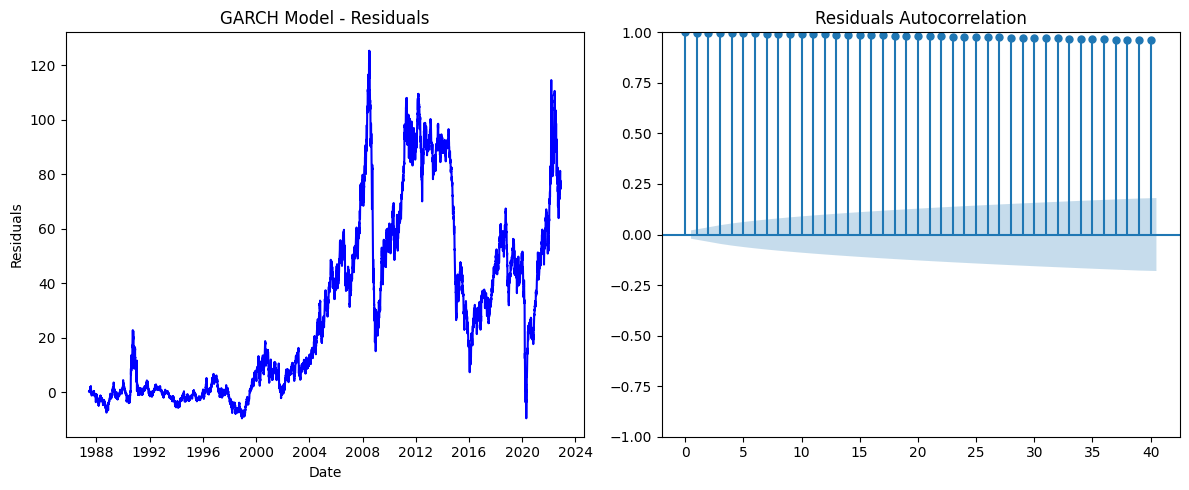

In [26]:
 # GARCH Model on Log Returns
residual_analysis(garch_result, title="GARCH Model")

##### merging the different data

In [16]:
import pandas as pd

# Load Brent oil prices
brent_prices = pd.read_csv('C:/Users/elbet/OneDrive/Desktop/Ten/week-10/Change-point-analysis-and-statistical-modelling-of-time-series-data/data/BrentOilPrices.csv', parse_dates=['Date'])

# Load the historical events data
events_data = pd.read_csv('C:/Users/elbet/OneDrive/Desktop/Ten/week-10/Change-point-analysis-and-statistical-modelling-of-time-series-data/data/oil_related_events.csv')

# Ensure the event year is in datetime format for merging
events_data['Year'] = pd.to_datetime(events_data['Year'], format='%Y')

# Merge datasets based on year
merged_data = pd.merge_asof(
    brent_prices.sort_values('Date'), 
    events_data.sort_values('Year'), 
    left_on='Date', 
    right_on='Year', 
    direction='backward'  # Align the closest previous event
)

# Save to CSV
merged_data.to_csv('merged_brent_oil_price_and_related_events.csv', index=False)
# Display the merged dataset
print(merged_data.head())


        Date  Price Year Event
0 1987-05-20  18.63  NaT   NaN
1 1987-05-21  18.45  NaT   NaN
2 1987-05-22  18.55  NaT   NaN
3 1987-05-25  18.60  NaT   NaN
4 1987-05-26  18.63  NaT   NaN
